In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/DZStem/ADAML_Workshop5/main/Stock/AAPL.csv'
df1 = pd.read_csv(url)
df1 = df1.set_index('date')
df1 = df1.iloc[3:]
print(df1)

                           Unnamed: 0 symbol    close     high       low  \
date                                                                       
2015-06-01 00:00:00+00:00           3   AAPL  130.535  131.390  130.0500   
2015-06-02 00:00:00+00:00           4   AAPL  129.960  130.655  129.3200   
2015-06-03 00:00:00+00:00           5   AAPL  130.120  130.940  129.9000   
2015-06-04 00:00:00+00:00           6   AAPL  129.360  130.580  128.9100   
2015-06-05 00:00:00+00:00           7   AAPL  128.650  129.690  128.3600   
...                               ...    ...      ...      ...       ...   
2020-05-18 00:00:00+00:00        1253   AAPL  314.960  316.500  310.3241   
2020-05-19 00:00:00+00:00        1254   AAPL  313.140  318.520  313.0100   
2020-05-20 00:00:00+00:00        1255   AAPL  319.230  319.520  316.2000   
2020-05-21 00:00:00+00:00        1256   AAPL  316.850  320.890  315.8700   
2020-05-22 00:00:00+00:00        1257   AAPL  318.890  319.230  315.3500   

           

Prepare the data

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

T = 10
X = []
Y = []

target_column = 'close'
series = df1[target_column]
serious = df1 # For multivariate LSTM

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1,T)
Y = np.array(Y)
N = len(X)

print(X)
print(Y)

[[130.535 129.96  130.12  ... 128.88  128.59  127.17 ]
 [129.96  130.12  129.36  ... 128.59  127.17  126.92 ]
 [130.12  129.36  128.65  ... 127.17  126.92  127.6  ]
 ...
 [300.63  303.74  310.13  ... 307.71  314.96  313.14 ]
 [303.74  310.13  315.01  ... 314.96  313.14  319.23 ]
 [310.13  315.01  311.41  ... 313.14  319.23  316.85 ]]
[126.92 127.6  127.3  ... 319.23 316.85 318.89]


<ipython-input-3-fc2d034c6fd4>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = series[t+T]


Linear regression (AR)

Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2369.4854 - val_loss: 1167.6593
Epoch 2/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 231.2368 - val_loss: 105.3433
Epoch 3/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54.7017 - val_loss: 89.6701
Epoch 4/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.5919 - val_loss: 69.1513
Epoch 5/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.2160 - val_loss: 64.9981
Epoch 6/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.2776 - val_loss: 66.9324
Epoch 7/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.8672 - val_loss: 72.3018
Epoch 8/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.2808 - val_loss: 137.5382
Epoch 9/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.9890 - val_loss: 60.7831
Epoch 10/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0246 - val_loss: 67.0660
Epoch 11/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.6335 - val_loss: 61.8057
Epoch 12/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

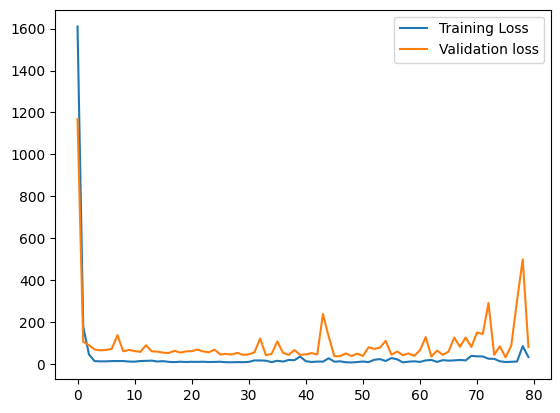

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import SGD, Adam
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

i = Input(shape=(T,))
x = Dense(1)(i)
# Create a linear regression model
model = Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.1)
)

# Train the model on the training data
r = model.fit(X[:-N//2], Y[:-N//2],
          epochs=80,
          validation_data=(X[-N//2:], Y[-N//2:])
)

plt.plot(r.history["loss"], label="Training Loss")
plt.plot(r.history["val_loss"], label="Validation loss")
plt.legend()

validation_target = Y[-N//2:]
validation_predictions = []
last_x = X[-N//2]

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,-1), verbose=0)[0,0]
  validation_predictions.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# Evaluate the model
mse = mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

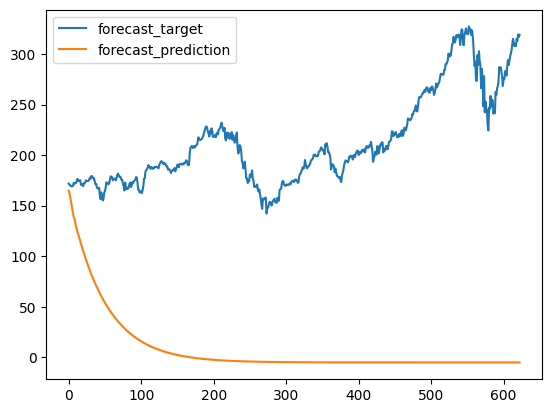

In [ ]:

# Plot the true values
plt.plot(validation_target, label="forecast_target")
plt.plot(validation_predictions, label="forecast_prediction")
plt.legend()

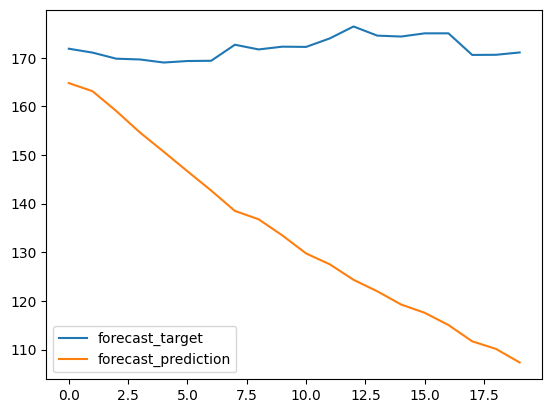

In [ ]:
# Plot the true values
plt.plot(validation_target[0:20], label="forecast_target")
plt.plot(validation_predictions[0:20], label="forecast_prediction")
plt.legend()

In [ ]:
# Evaluate the model
mse = mean_squared_error(validation_target[0:20], validation_predictions[0:20])
r2 = r2_score(validation_target[0:20], validation_predictions[0:20])

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1822.5888247662253
R-squared: -389.33041272966165


Now we do LSTM

In [ ]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have a 1D time series data as a NumPy array
# Replace this with your actual data
data = serious # Using multivariate data
data = data.drop(['Unnamed: 0', 'symbol'], axis=1)
data = data.values
print(data)
# Reshape the data to be a column vector
data = data.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define the sequence length (number of time steps for each input sequence)
sequence_length = 20

# Prepare sequences for input (X) and output (Y)
X, Y = [], []

for i in range(len(data_normalized) - sequence_length):
    # Input sequence
    x_sequence = data_normalized[i:i + sequence_length]
    print(x_sequence)
    # Output sequence (target)
    y_sequence = data_normalized[i + sequence_length]
    print(y_sequence)

    X.append(x_sequence)
    Y.append(y_sequence)

Streaming output truncated to the last 5000 lines.
 [1.74573992e-06]]
[1.75418596e-06]
[[1.73240507e-06]
 [1.69010180e-06]
 [1.69625053e-06]
 [1.92369739e-01]
 [0.00000000e+00]
 [6.16498896e-09]
 [1.74450693e-06]
 [1.74475353e-06]
 [1.70770194e-06]
 [1.70893494e-06]
 [1.94981234e-01]
 [1.73990652e-06]
 [1.74015247e-06]
 [1.70319860e-06]
 [1.70442834e-06]
 [1.94981234e-01]
 [0.00000000e+00]
 [6.16498896e-09]
 [1.74573992e-06]
 [1.75418596e-06]]
[1.72588866e-06]
[[1.69010180e-06]
 [1.69625053e-06]
 [1.92369739e-01]
 [0.00000000e+00]
 [6.16498896e-09]
 [1.74450693e-06]
 [1.74475353e-06]
 [1.70770194e-06]
 [1.70893494e-06]
 [1.94981234e-01]
 [1.73990652e-06]
 [1.74015247e-06]
 [1.70319860e-06]
 [1.70442834e-06]
 [1.94981234e-01]
 [0.00000000e+00]
 [6.16498896e-09]
 [1.74573992e-06]
 [1.75418596e-06]
 [1.72588866e-06]]
[1.73729389e-06]
[[1.69625053e-06]
 [1.92369739e-01]
 [0.00000000e+00]
 [6.16498896e-09]
 [1.74450693e-06]
 [1.74475353e-06]
 [1.70770194e-06]
 [1.70893494e-06]
 [1.94981234e

[[1.3053500e+02 1.3139000e+02 1.3005000e+02 ... 3.2112797e+07
  0.0000000e+00 1.0000000e+00]
 [1.2996000e+02 1.3065500e+02 1.2932000e+02 ... 3.3667627e+07
  0.0000000e+00 1.0000000e+00]
 [1.3012000e+02 1.3094000e+02 1.2990000e+02 ... 3.0983542e+07
  0.0000000e+00 1.0000000e+00]
 ...
 [3.1923000e+02 3.1952000e+02 3.1620000e+02 ... 2.7876215e+07
  0.0000000e+00 1.0000000e+00]
 [3.1685000e+02 3.2089000e+02 3.1587000e+02 ... 2.5672211e+07
  0.0000000e+00 1.0000000e+00]
 [3.1889000e+02 3.1923000e+02 3.1535000e+02 ... 2.0450754e+07
  0.0000000e+00 1.0000000e+00]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

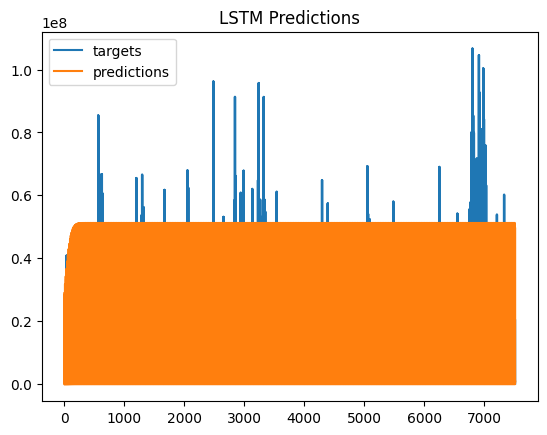

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have a 1D time series data as a NumPy array
# Replace this with your actual data
data = serious # Using multivariate data
data = data.drop(['Unnamed: 0', 'symbol'], axis=1)
data = data.values
print(data)
# Reshape the data to be a column vector
data = data.reshape(-1, 1)

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define the sequence length (number of time steps for each input sequence)
sequence_length = 20

# Prepare sequences for input (X) and output (Y)
X, Y = [], []

for i in range(len(data_normalized) - sequence_length):
    # Input sequence
    x_sequence = data_normalized[i:i + sequence_length]
    print(x_sequence)
    # Output sequence (target)
    y_sequence = data_normalized[i + sequence_length]
    print(y_sequence)

    X.append(x_sequence)
    Y.append(y_sequence)

# Convert the lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data into training and testing sets (80% training, 20% testing)
split_ratio = 0.5
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=80, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training set
model.fit(X_train, Y_train, epochs=100, batch_size=20, verbose=0)

# Use the trained model to make predictions on the test set
predictions = model.predict(X_test)

# Inference using predicted values as input for the next prediction
validation_target = Y_test
validation_predictions = []

last_x = X_test[0]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, sequence_length, 1))[0, 0]
    validation_predictions.append(p)
    last_x = np.roll(last_x, -1, axis=0)
    last_x[-1] = p

# Denormalize the predictions for better interpretation
validation_predictions = scaler.inverse_transform(np.array(validation_predictions).reshape(-1, 1))
validation_target = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))

plt.plot(validation_target, label="targets")
plt.plot(validation_predictions, label="predictions")
plt.title("LSTM Predictions")
plt.legend()
plt.show

# Evaluate the model
mse = mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

<function matplotlib.pyplot.show(close=None, block=None)>

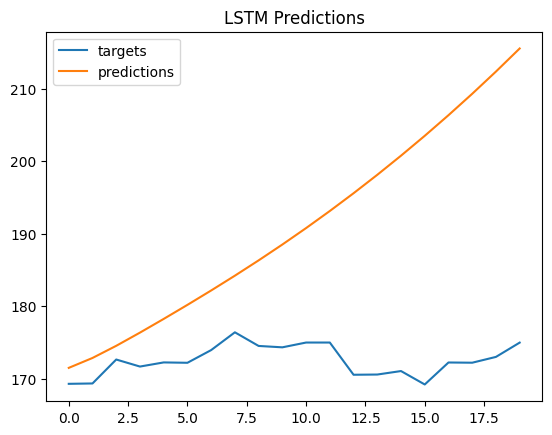

In [ ]:
plt.plot(validation_target[0:20], label="targets")
plt.plot(validation_predictions[0:20], label="predictions")
plt.title("LSTM Predictions")
plt.legend()
plt.show

In [ ]:
# Evaluate the model
mse = mean_squared_error(validation_target[0:20], validation_predictions[0:20])
r2 = r2_score(validation_target[0:20], validation_predictions[0:20])

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 517.5859299908105
R-squared: -120.65529025766044


Transformer model

In [ ]:
!pip install transformers


NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
!pip install -q transformers

!pip install -q datasets

!pip install -q evaluate

!pip install -q accelerate

!pip install -q gluonts ujson


from datasets import load_dataset

##



NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
from datasets import Dataset, DatasetDict

df1.index = pd.to_datetime(df1.index)

# Resample the data by month and get the values for each month
monthly_data = df1.resample('M').agg(lambda x: x.tolist())

# Calculate the index to split the data into train and validation (80-20 split)
split_index = int(22/2)
split_val = int(22/2 + 22/4)


# Create 'train' and 'validation' dictionaries
train_dataset = {
    'start': monthly_data.index,
    'target': [month[:split_val] for month in monthly_data['close']],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

validation_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['close'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

test_dataset = {
    'start': monthly_data.index,
    'target': monthly_data['close'],
    'item_id': list(range(1, len(monthly_data) + 1)),
    'feat_dynamic_real': len(monthly_data)*[None],
    'feat_static_cat': list(range(1, len(monthly_data) + 1))
}

# Create Dataset objects
train_dataset = Dataset.from_dict(train_dataset)
test_dataset = Dataset.from_dict(test_dataset)
validation_dataset = Dataset.from_dict(validation_dataset)

# Create the DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

# Display or use the dataset_dict as needed
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
    test: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
})


<ipython-input-255-2332037a218f>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df1.resample('M').agg(lambda x: x.tolist())


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
    validation: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
    test: Dataset({
        features: ['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'],
        num_rows: 60
    })
})

In [ ]:
validation_example = dataset['validation'][0]
train_example = dataset['train'][0]
validation_example.keys()

dict_keys(['start', 'target', 'item_id', 'feat_dynamic_real', 'feat_static_cat'])

In [ ]:
print(validation_example['start'])
print(validation_example['target'])
print(train_example['start'])
print(train_example['target'])

2015-06-30 00:00:00+00:00
[130.535, 129.96, 130.12, 129.36, 128.65, 127.8, 127.42, 128.88, 128.59, 127.17, 126.92, 127.6, 127.3, 127.88, 126.6, 127.61, 127.03, 128.11, 127.5, 126.75, 124.53, 125.425]
2015-06-30 00:00:00+00:00
[130.535, 129.96, 130.12, 129.36, 128.65, 127.8, 127.42, 128.88, 128.59, 127.17, 126.92, 127.6, 127.3, 127.88, 126.6, 127.61]


In [ ]:
len(train_example["target"])

16

In [ ]:
freq = "1D"
prediction_length = 22-16

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

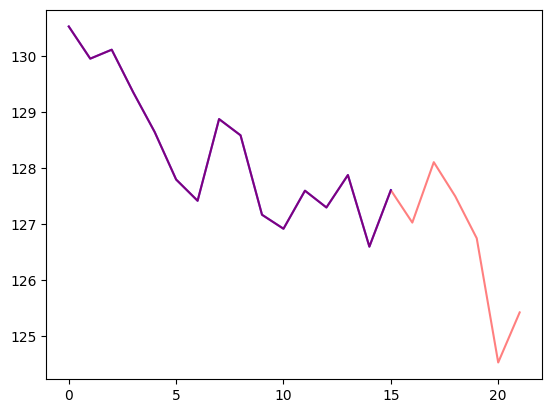

In [ ]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()



In [ ]:
train_dataset = dataset["train"]
test_dataset = dataset["train"]

In [ ]:
from functools import lru_cache

import pandas as pd
import numpy as np


def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [ ]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [ ]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)


[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [ ]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x799fc7006e60>, <function day_of_month at 0x799fc7006f80>, <function day_of_year at 0x799fc70070a0>]


In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=0,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [ ]:
model.config.distribution_output

'student_t'

In [ ]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [ ]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )



In [ ]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [ ]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [ ]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )



In [ ]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)


In [ ]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())


past_time_features torch.Size([64, 1105, 4]) torch.FloatTensor
past_values torch.Size([64, 1105]) torch.FloatTensor
past_observed_mask torch.Size([64, 1105]) torch.FloatTensor
future_time_features torch.Size([64, 6, 4]) torch.FloatTensor
future_values torch.Size([64, 6]) torch.FloatTensor
future_observed_mask torch.Size([64, 6]) torch.FloatTensor


In [ ]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [ ]:
print("Loss:", outputs.loss.item())

Loss: 6.564791202545166


Traiing the model

In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)

lr_1 = 5e-5
lr_2 = 5e-4
lr_3 = 5e-3
lr_4 = 5e-6
lr_5 = 5e-7
optimizer = AdamW(model.parameters(), lr=lr_1, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Ensure the input tensors have the correct data type
        static_categorical_features = (
            batch["static_categorical_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_categorical_features > 0
            else None
        )

        static_real_features = (
            batch["static_real_features"]
            .to(device)
            .to(torch.float)  # Convert to float if not already
            if config.num_static_real_features > 0
            else None
        )

        past_time_features = batch["past_time_features"].to(device)
        past_values = batch["past_values"].to(device)
        future_time_features = batch["future_time_features"].to(device)
        future_values = batch["future_values"].to(device)
        past_observed_mask = batch["past_observed_mask"].to(device)
        future_observed_mask = batch["future_observed_mask"].to(device)

        outputs = model(
            static_categorical_features=static_categorical_features,
            static_real_features=static_real_features,
            past_time_features=past_time_features,
            past_values=past_values,
            future_time_features=future_time_features,
            future_values=future_values,
            past_observed_mask=past_observed_mask,
            future_observed_mask=future_observed_mask,
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

6.642383575439453
6.32280158996582
5.929119110107422
5.810487270355225
5.711022853851318
5.64332389831543
5.372514247894287
5.351613521575928
5.369615077972412
5.373353958129883
5.249582290649414
5.0891876220703125
5.097799301147461
4.978104591369629
4.947229385375977
4.90606164932251
4.94242525100708
4.895911693572998
4.911187648773193
4.683552265167236
4.701574802398682
4.646481990814209
4.700809955596924
4.75773811340332
4.5168585777282715
4.436327934265137
4.434875011444092
4.524542331695557
4.412411212921143
4.390994071960449
4.418104648590088
4.289304256439209
4.361763954162598
4.460754871368408
4.153849124908447
4.236243724822998
4.228936672210693
4.304538726806641
4.310011386871338
4.504042148590088


In [ ]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [ ]:
forecasts[0].shape

(60, 100, 6)

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(60, 100, 6)


In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)


In [ ]:
import matplotlib.dates as mdates


def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=validation_dataset[ts_index][FieldName.START],
        periods=len(validation_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()


    # Major ticks every day
    ax.xaxis.set_major_locator(mdates.DayLocator())
    # Minor ticks every 6 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    ax.plot(
        index,
        validation_dataset[ts_index]["target"],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

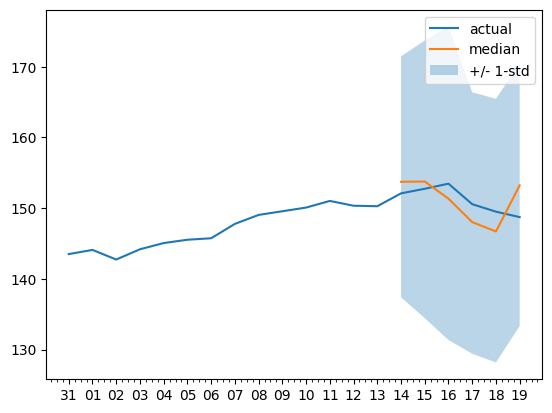

In [ ]:
plot(25)

Error evaluation

In [ ]:
# Added actual and predicted value lists for MSE and R^2
index = pd.period_range(
        start=validation_dataset[25][FieldName.START],
        periods=len(validation_dataset[25][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

pred_vals = np.median(forecasts[25], axis=0)
actual_vals = validation_dataset[25]["target"]


actuals = actual_vals[-6:]
preds = pred_vals

In [ ]:
# Evaluate the model
mse = mean_squared_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 7.110500617334824
R-squared: -1.4145078659057617
